In [2]:
import pandas as pd


# This notebook will set up the data we need to run our linear regressions.

# First, load the datasets we will need.
pop = pd.read_csv("../data/CA_pop.csv")
crime = pd.read_csv("../data/clean_data.csv", low_memory=False)
lstops = pd.read_csv("../data/lstops_localized.csv")
parks = pd.read_csv("../data/parks_localized.csv")
#print(CA_pop.head())
print(lstops.head())
print(lstops.columns)
#print(parks.columns)
print(pop.head())


   STOP_ID DIRECTION_ID                 STOP_NAME STATION_NAME  \
0    30162            W  18th (54th/Cermak-bound)         18th   
1    30162            W  18th (54th/Cermak-bound)         18th   
2    30162            W  18th (54th/Cermak-bound)         18th   
3    30162            W  18th (54th/Cermak-bound)         18th   
4    30162            W  18th (54th/Cermak-bound)         18th   

  STATION_DESCRIPTIVE_NAME  MAP_ID   ADA    RED   BLUE      G  ...      Y  \
0         18th (Pink Line)   40830  True  False  False  False  ...  False   
1         18th (Pink Line)   40830  True  False  False  False  ...  False   
2         18th (Pink Line)   40830  True  False  False  False  ...  False   
3         18th (Pink Line)   40830  True  False  False  False  ...  False   
4         18th (Pink Line)   40830  True  False  False  False  ...  False   

    Pnk      O               Location        Lat        Lon   zips  \
0  True  False  41.857908, -87.669147  41.857908 -87.669147  60608   


In [362]:
# Now we need to get the columns that we need and build our data frames
# We will make two data frames: crime_time and conditions
# crime_time: Crime rates by Community 
# conditions: Acerage of parks and number of L train stops by Community

# First, we'll make conditions

parks1 = parks.filter(['ACRES','Community Area','Pop2010'], axis=1)
parks1 = parks1.groupby('Community Area')[['ACRES']].agg('sum')
parks1 = parks1.reset_index()
parks1.columns = ['Community Area','Acres']
print(parks1.head())


lstops1 = lstops['Community Area'].value_counts()
lstops1 = lstops1.reset_index()
lstops1.columns = ['Community Area','Num L Stops']
lstops1['Num L Stops'] = lstops1['Num L Stops'].fillna(0)
print(lstops1)

pop.columns = ['Community Area', 'Pop2010','weights','total']
print(pop)

# Do the same sort of grouping for any other datasets we want to consider

   Community Area        Acres
0               1   284.460000
1               2   390.560000
2               3    30.740000
3               4   389.422277
4               5  1395.020000
    Community Area  Num L Stops
0               32           50
1               28           48
2               24           38
3               29           36
4                7           36
..             ...          ...
62              67            2
63              53            2
64              54            2
65              19            2
66              65            2

[67 rows x 2 columns]
    Community Area  Pop2010   weights      total
0                1    63484  0.021921  2896016.0
1                2    73199  0.025276        NaN
2                3    63551  0.021944        NaN
3                4    44574  0.015391        NaN
4                5    31895  0.011013        NaN
..             ...      ...       ...        ...
72              73    29843  0.010305        NaN
73             

In [382]:
# merge the datasets now to get all of the attributes of each community
# in one place.
# For now, we are only looking at two attributes, so we do a single merge
conditions = pd.merge(pop, parks1, left_on=['Community Area'], right_on=['Community Area'], how = 'left')
conditions = pd.merge(conditions, lstops1, left_on=['Community Area'], right_on=['Community Area'], how = 'left')
#print(conditions.head())
#print(pop.head())
#weights = pop.filter(['Community','pop2010','w'])
#weights = weights.rename(columns={'Community':'Community Area'})
#print(weights.columns)
#conditions = conditions.merge(weights)
print(conditions)
# Now conditions dataframe is ready and has all the information we need
# (until we examine more factors beyond Acres of park-space and number of L stops).

    Community Area  Pop2010   weights      total        Acres  Num L Stops
0                1    63484  0.021921  2896016.0   284.460000         16.0
1                2    73199  0.025276        NaN   390.560000         16.0
2                3    63551  0.021944        NaN    30.740000         22.0
3                4    44574  0.015391        NaN   389.422277         32.0
4                5    31895  0.011013        NaN  1395.020000         34.0
..             ...      ...       ...        ...          ...          ...
72              73    29843  0.010305        NaN   527.615113          6.0
73              74    18820  0.006499        NaN    92.960000          NaN
74              75    25226  0.008711        NaN   504.995113          2.0
75              76    11956  0.004128        NaN   120.980000          6.0
76              77    62198  0.021477        NaN    41.020000         16.0

[77 rows x 6 columns]


In [383]:
# Now we will make the crime_time dataframe.
# We will calculate the crime rate for each Community for every month in the past
# five years.

# First, filter out the data before 2015
# Second, calculate crime rate
#   rate := total crime in that community / total crime that month
# Third, build the crime_time dataset
crime1 = crime.filter(['Month','Year','Community Area'])
#print(crime1.head())

after_2015 = crime1['Year'] >= 2015
crime1 = crime1[after_2015]
crime_CA = crime1.copy()
print(crime1.head())

crime1.set_index('Year')
print("The following dataframe has the number of crimes in each community for each month since Jan 2015:")


crime2 = crime1.groupby(['Year','Month','Community Area']).agg(count = ('Community Area','count'))
#print(crime2)

crime3 = crime2.reset_index()
print(crime3)

# Get the total crimes reported per month
totals = crime2.groupby(['Year','Month']).agg('sum')
#print(totals)
tot = totals.reset_index()
print(tot)

wow_crimes = pd.merge(crime3, tot, left_on=['Year','Month'], right_on=['Year', 'Month'], how = 'left')
wow_crimes


   Month  Year  Community Area
1     10  2017            73.0
2      3  2017            70.0
3      9  2017            42.0
4      8  2017            32.0
5      1  2015            65.0
The following dataframe has the number of crimes in each community for each month since Jan 2015:
      Year  Month  Community Area  count
0     2015      1             1.0    295
1     2015      1             2.0    251
2     2015      1             3.0    245
3     2015      1             4.0    156
4     2015      1             5.0    112
...    ...    ...             ...    ...
5462  2020     11            73.0    151
5463  2020     11            74.0     36
5464  2020     11            75.0    121
5465  2020     11            76.0     64
5466  2020     11            77.0    115

[5467 rows x 4 columns]
    Year  Month  count
0   2015      1  20918
1   2015      2  16383
2   2015      3  21668
3   2015      4  21714
4   2015      5  23690
..   ...    ...    ...
66  2020      7  19349
67  2020      8

,Year,Month,Community Area,count_x,count_y
0,2015,1,1.0,295,20918
1,2015,1,2.0,251,20918
2,2015,1,3.0,245,20918
3,2015,1,4.0,156,20918
4,2015,1,5.0,112,20918
...,...,...,...,...,...
5462,2020,11,73.0,151,11218
5463,2020,11,74.0,36,11218
5464,2020,11,75.0,121,11218
5465,2020,11,76.0,64,11218


In [384]:
'''
TODO: 
Need to find a way to convert the number of crimes committed in each community
to a decimal fraction based on the total crime committed that month.
I have both dataframes made, just not sure how best to apply the conversion.
This is where I am leaving off.
'''

# Calculate the rate and complete the dataframe

wow_crimes['rate'] = wow_crimes['count_x']/wow_crimes['count_y']
print("\nCompleted crime_time dataset:\n")
print(wow_crimes)


Completed crime_time dataset:

      Year  Month  Community Area  count_x  count_y      rate
0     2015      1             1.0      295    20918  0.014103
1     2015      1             2.0      251    20918  0.011999
2     2015      1             3.0      245    20918  0.011712
3     2015      1             4.0      156    20918  0.007458
4     2015      1             5.0      112    20918  0.005354
...    ...    ...             ...      ...      ...       ...
5462  2020     11            73.0      151    11218  0.013461
5463  2020     11            74.0       36    11218  0.003209
5464  2020     11            75.0      121    11218  0.010786
5465  2020     11            76.0       64    11218  0.005705
5466  2020     11            77.0      115    11218  0.010251

[5467 rows x 6 columns]


In [385]:
"We then isolate the rates according to each Community Area to find "
#dict to store average crime rates
ca_average = {} 

#dict to store df for each community
ca_rates = {}

for i in range(1,78):
    area_rate = wow_crimes[wow_crimes['Community Area'] == i]
    ca_rates[i] = area_rate
    average = area_rate['rate'].mean()
    d=ca_average[i] = average

print(ca_rates)

{1:       Year  Month  Community Area  count_x  count_y      rate
0     2015      1             1.0      295    20918  0.014103
77    2015      2             1.0      246    16383  0.015016
154   2015      3             1.0      292    21668  0.013476
231   2015      4             1.0      237    21714  0.010915
308   2015      5             1.0      331    23690  0.013972
...    ...    ...             ...      ...      ...       ...
5082  2020      7             1.0      290    19349  0.014988
5159  2020      8             1.0      315    19610  0.016063
5236  2020      9             1.0      279    17604  0.015849
5313  2020     10             1.0      294    17915  0.016411
5390  2020     11             1.0      156    11218  0.013906

[71 rows x 6 columns], 2:       Year  Month  Community Area  count_x  count_y      rate
1     2015      1             2.0      251    20918  0.011999
78    2015      2             2.0      222    16383  0.013551
155   2015      3             2.0      

In [386]:
#segment into 2015-2019 and 2020 for each community area
d_rate = {}
for i in range(1,78):
    dd = {}
    ca_data = ca_rates[i]
    old_data = ca_data[ca_data['Year'] != 2020]
    new_data = ca_data[ca_data['Year'] == 2020]
    dd['old'] = old_data
    dd['new'] = new_data
    d_rate[i] = dd
print(d_rate)
    

    

{1: {'old':       Year  Month  Community Area  count_x  count_y      rate
0     2015      1             1.0      295    20918  0.014103
77    2015      2             1.0      246    16383  0.015016
154   2015      3             1.0      292    21668  0.013476
231   2015      4             1.0      237    21714  0.010915
308   2015      5             1.0      331    23690  0.013972
385   2015      6             1.0      298    23173  0.012860
462   2015      7             1.0      361    24217  0.014907
539   2015      8             1.0      314    24801  0.012661
616   2015      9             1.0      344    23105  0.014889
693   2015     10             1.0      337    23082  0.014600
770   2015     11             1.0      260    20577  0.012635
847   2015     12             1.0      278    21132  0.013155
924   2016      1             1.0      309    20704  0.014925
1001  2016      2             1.0      270    18731  0.014415
1078  2016      3             1.0      307    22038  0.013

5466  2020     11            77.0      115    11218  0.010251}}


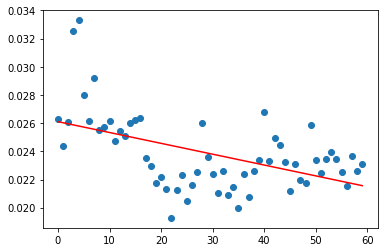

In [387]:
from sklearn.linear_model import LinearRegression as lr
import matplotlib.pyplot as plt
import datetime
import numpy as np

#test plot of rate over five years for CA 68
Y1 = d_rate[68]['old']['rate']
X1 = range(len(Y1))

X1 = np.array(X1)
Y1 = Y1.to_numpy()
Y = Y1.reshape(-1,1)
X = X1.reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

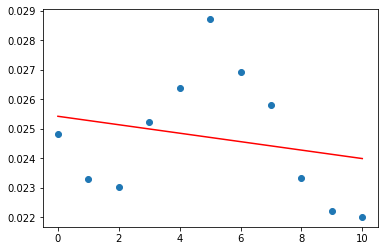

In [388]:
#test plot of rate over five years
Y1 = d_rate[68]['new']['rate']
X1 = range(len(Y1))

X1 = np.array(X1)
Y1 = Y1.to_numpy()
Y = Y1.reshape(-1,1)
X = X1.reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

In [389]:
#given seasonality of data, it makes more sense to compare month to month by year instead of yearly data 
# so we resegment by month for each community area
#SKIP FOR NOW

In [390]:
#figure out old_rate vs new_rate for each CA (averaging over all years past to average of this year to account for seasonal data)
#note here: does not account for slope over time as all data points over last 15 years treated equally

seq = range(1,78)
list_old = []
list_new = []
#create average over past before 2020
for i in range(1,78):
    list_old.append(d_rate[i]['old']['rate'].mean())
    list_new.append(d_rate[i]['new']['rate'].mean())
    
df = pd.DataFrame(seq, columns = ['Community Area'])
df['old_rate'] = list_old
df['new_rate'] = list_new
df['percent_change'] = ((df['new_rate'] - df['old_rate']) / df['old_rate'])*100
df


,Community Area,old_rate,new_rate,percent_change
0,1,0.014495,0.015460,6.654484
1,2,0.012783,0.014529,13.655785
2,3,0.013363,0.013953,4.416243
3,4,0.007146,0.008800,23.146307
4,5,0.005150,0.005360,4.064089
...,...,...,...,...
72,73,0.011968,0.012501,4.454103
73,74,0.002147,0.002263,5.419855
74,75,0.007700,0.008134,5.634775
75,76,0.006470,0.005221,-19.301504


In [391]:
#merge with conditions
df_final = pd.merge(df, conditions, left_on=['Community Area'], right_on=['Community Area'], how = 'left')
df_final['Num L Stops'] = df_final['Num L Stops'].fillna(0)
df_final['Acres'] = df_final['Acres'].fillna(0)
df_final

,Community Area,old_rate,new_rate,percent_change,Pop2010,weights,total,Acres,Num L Stops
0,1,0.014495,0.015460,6.654484,63484,0.021921,2896016.0,284.460000,16.0
1,2,0.012783,0.014529,13.655785,73199,0.025276,NaN,390.560000,16.0
2,3,0.013363,0.013953,4.416243,63551,0.021944,NaN,30.740000,22.0
3,4,0.007146,0.008800,23.146307,44574,0.015391,NaN,389.422277,32.0
4,5,0.005150,0.005360,4.064089,31895,0.011013,NaN,1395.020000,34.0
...,...,...,...,...,...,...,...,...,...
72,73,0.011968,0.012501,4.454103,29843,0.010305,NaN,527.615113,6.0
73,74,0.002147,0.002263,5.419855,18820,0.006499,NaN,92.960000,0.0
74,75,0.007700,0.008134,5.634775,25226,0.008711,NaN,504.995113,2.0
75,76,0.006470,0.005221,-19.301504,11956,0.004128,NaN,120.980000,6.0


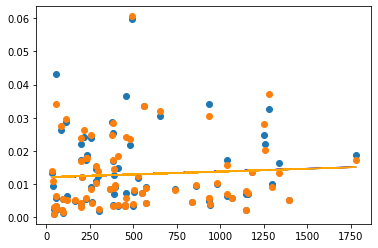

In [431]:
#greenspace vs. crime rate for each community area

#mapping greenspace by old_rate in crime 

X = df_final['Acres'].to_numpy().reshape(-1,1)
Y = df_final['old_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'blue')

#mapping greenspace by new_rate in crime 
X = df_final['Acres'].to_numpy().reshape(-1,1)
Y = df_final['new_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'orange')

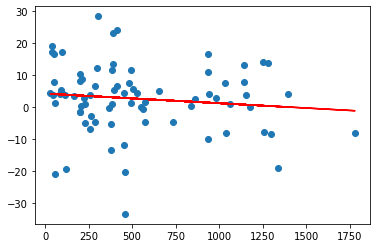

In [428]:

#mapping greenspace by percent change in crime 
X = df_final['Acres'].to_numpy().reshape(-1,1)
Y = df_final['percent_change'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

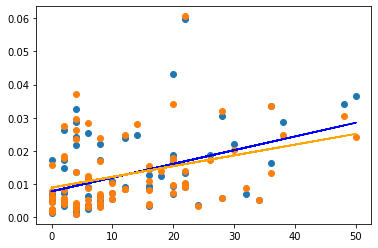

In [432]:
#mapping lstops by old_rate in crime 
X = df_final['Num L Stops'].to_numpy().reshape(-1,1)
Y = df_final['old_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'blue')

#mapping lstops by new_rate in crime 
X = df_final['Num L Stops'].to_numpy().reshape(-1,1)
Y = df_final['new_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'orange')

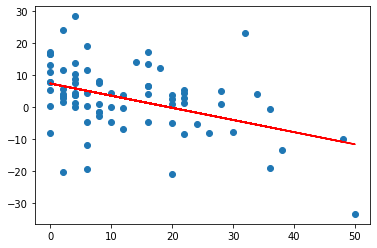

In [435]:
#mapping lstops by percent change in crime 
X = df_final['Num L Stops'].to_numpy().reshape(-1,1)
Y = df_final['percent_change'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

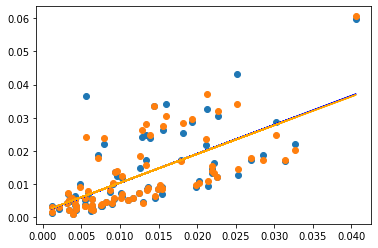

In [438]:
#mapping pop density with old_rate in crime 

X = df_final['weights'].to_numpy().reshape(-1,1)
Y = df_final['old_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'blue')

#mapping pop density with new_rate in crime 

X = df_final['weights'].to_numpy().reshape(-1,1)
Y = df_final['new_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'orange')

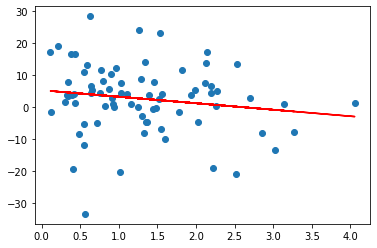

In [439]:
#mapping pop density by percent change in crime 

X = (df_final['weights']*100).to_numpy().reshape(-1,1)
Y = df_final['percent_change'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')